<a href="https://colab.research.google.com/github/thibaud-perrin/diffusion-model/blob/main/diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Model

## imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard, make_circles ,make_moons, make_s_curve, make_swiss_roll
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
plt.rcParams.update({
    "figure.facecolor":  (0, 0, 0, 1),
    "axes.facecolor":    (0.0, 0, 0.0, 1),
    "savefig.facecolor": (0.0, 0.0, 0, 1),
})

## Loading data
### swiss_roll

In [3]:
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0
swiss_roll.shape

(10000, 2)

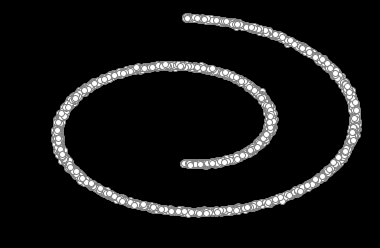

In [4]:
plt.scatter(swiss_roll[:, 0], swiss_roll[:, 1], c='w', edgecolor='gray')

### Curve

In [5]:
s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0
s_curve.shape

(10000, 2)

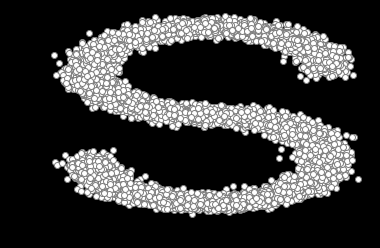

In [6]:
plt.scatter(s_curve[:, 0], s_curve[:, 1], c='w', edgecolor='gray')

### Moon

In [7]:
moons, _ = make_moons(10**4, noise=0.1)
moons.shape

(10000, 2)

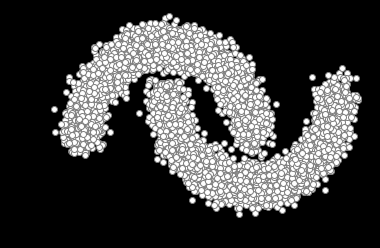

In [8]:
plt.scatter(moons[:, 0], moons[:, 1], c='w', edgecolor='gray')

## Utils

In [9]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [10]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

In [11]:
def noise_estimation_loss(model, x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

In [12]:
def p_sample(model, x, t,alphas,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

In [13]:
def p_sample_loop(model, shape,n_steps,alphas,betas,one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i,alphas,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

## Forward Diffusion

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

Substituting $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$: 

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

Given the initial state, this makes it possible to draw sample at any desrired timestep without going through intermediate steps. Forward diffusion can also be written in terms of $x_0$ and the random noise $\epsilon \sim \mathcal{N}(0,1)$.

$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

In [14]:
dataset = torch.Tensor(moons.T).float()

In [15]:
num_steps = 100
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [16]:
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

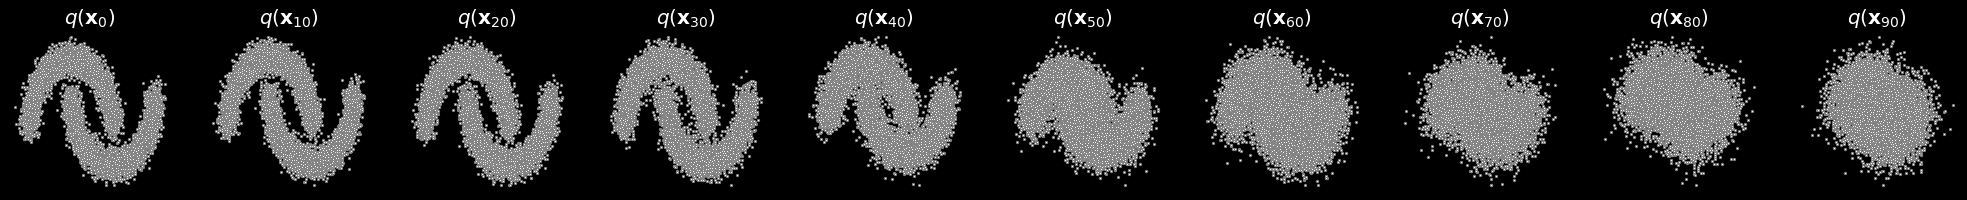

In [17]:
fig, axs = plt.subplots(1, 10, figsize=(35, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[0, :], q_i[1, :], c='w', edgecolor='gray', s=5);
    axs[i].set_axis_off()
    axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$', c='w', fontsize=20)

## Training

### Loss

The original loss was proposed in Sohl-Dickstein et al. as following:

\begin{align}
K = -\mathbb{E}_{q}[ &D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))  \\
&+ H_{q}(\mathbf{X}_{T}\vert\mathbf{X}_{0}) - H_{q}(\mathbf{X}_{1}\vert\mathbf{X}_{0}) - H_{p}(\mathbf{X}_{T})]
\end{align} 

In order to improve the results, the authors in Ho et al. proposed multiple improvements. Following Parameterization of mean is proposed: 

$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

further, variance is taken as constant and the step for reverse diffusion then becomes:

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$


After further improvements and simplifications the loss function becomes:

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

##### Exponential Moving Average Class

In [18]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

In [19]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

In [20]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

In [21]:
model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128

In [22]:
dataset = torch.Tensor(swiss_roll).float()

tensor(1.3069, grad_fn=<MeanBackward0>)
tensor(0.9390, grad_fn=<MeanBackward0>)
tensor(0.5097, grad_fn=<MeanBackward0>)
tensor(0.6391, grad_fn=<MeanBackward0>)
tensor(0.7506, grad_fn=<MeanBackward0>)
tensor(0.7627, grad_fn=<MeanBackward0>)
tensor(0.8879, grad_fn=<MeanBackward0>)
tensor(0.4630, grad_fn=<MeanBackward0>)
tensor(0.8840, grad_fn=<MeanBackward0>)
tensor(0.6063, grad_fn=<MeanBackward0>)


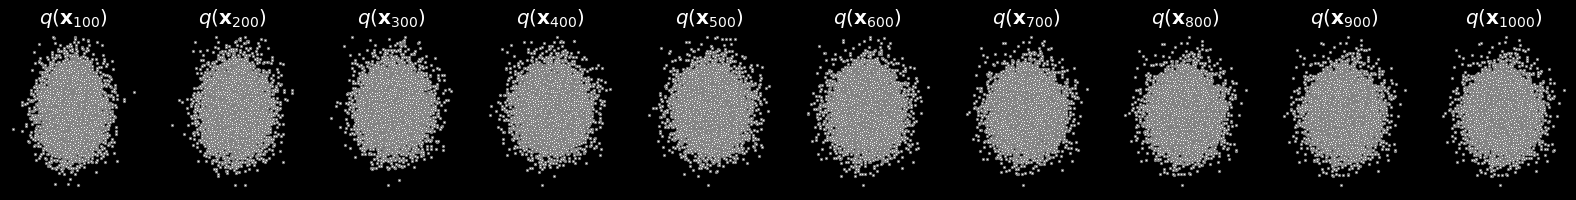

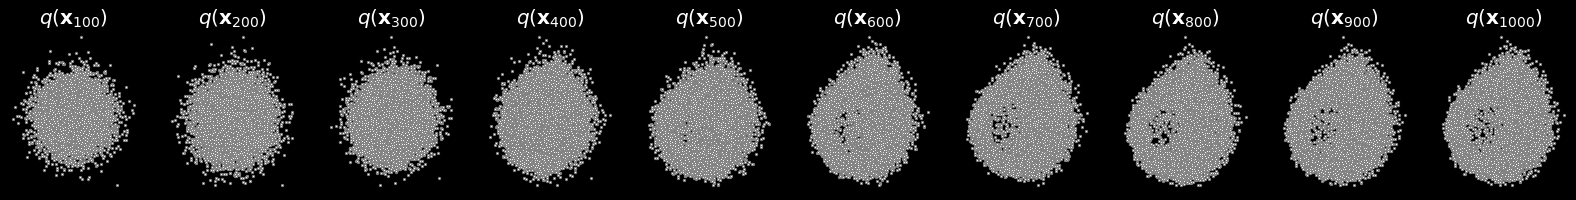

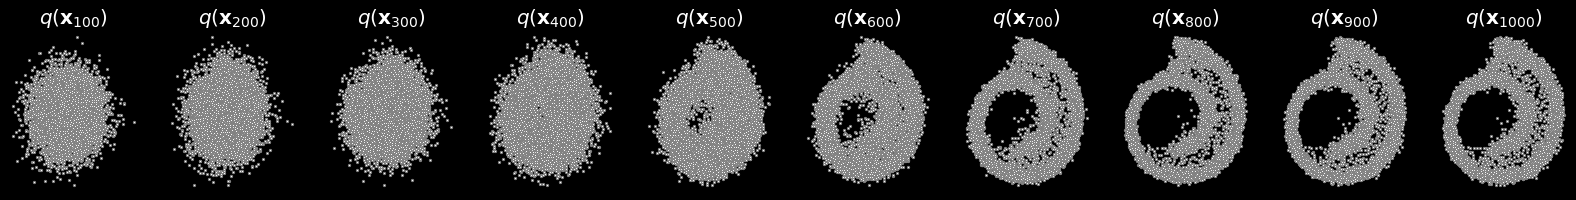

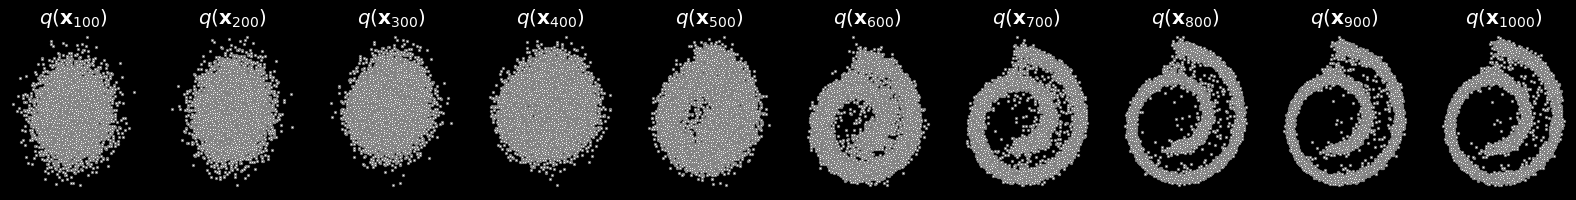

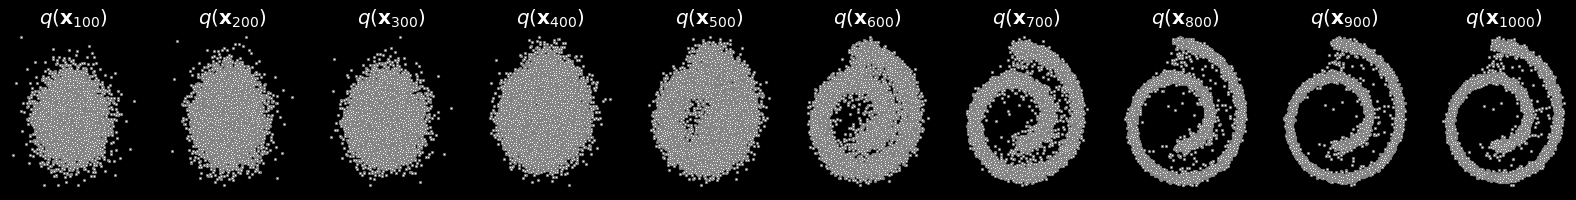

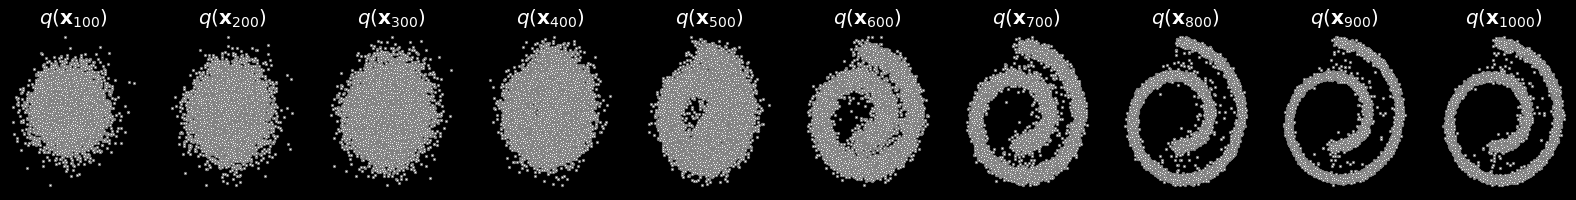

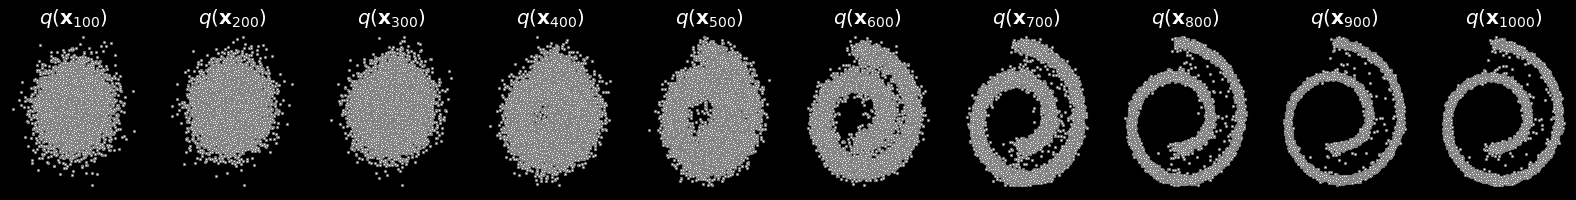

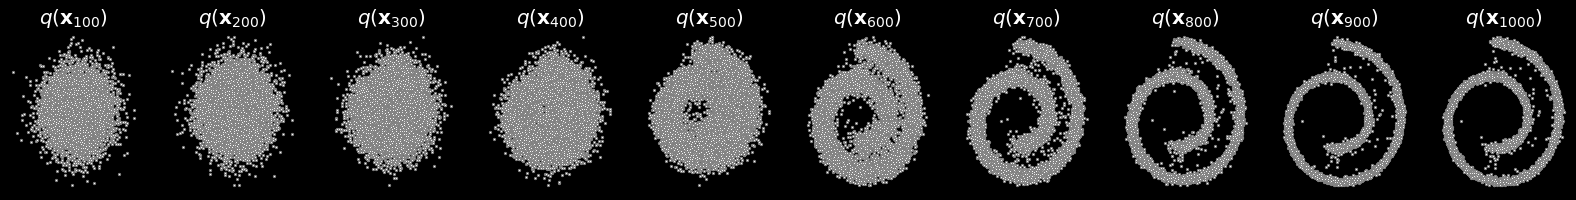

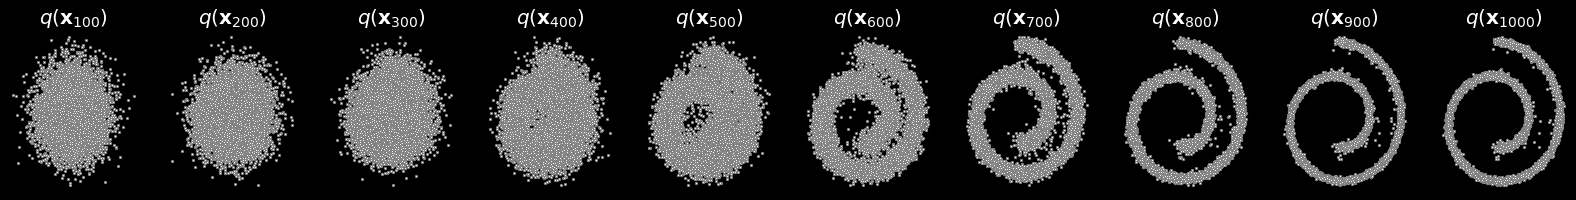

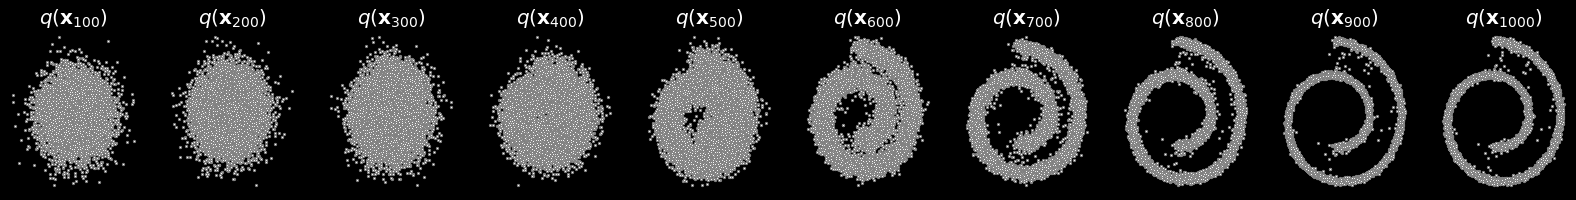

In [23]:
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, alphas, betas, one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], c='w', edgecolor='gray', s=5);
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$', c='w', fontsize=20)